# Raman Spectroscopy Data Preprocessing Pipeline

This notebook implements a complete data processing pipeline for Raman spectroscopy data:

1. **Data Loading**
   - Loading raw .npz files
   - Parsing metadata from filenames
   - Organizing spectra and metadata

2. **Preprocessing**
   - Baseline correction
   - Normalization
   - Signal enhancement
   
3. **Data Augmentation**
   - Noise injection
   - Peak shifting
   - Intensity scaling
   
4. **Dataset Creation**
   - Train/Validation/Test splitting
   - Data format standardization
   - Export for model training


In [1]:
# Standard library imports
import os
from glob import glob
from pathlib import Path

# Scientific computing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
sns.set_context("notebook", font_scale=1.2)


Loading data...
Loaded 923 spectra
Raman shift range: -125.1 to 2148.5 cm⁻¹
Unique concentrations: [0.0, 30.0, 50.0, 70.0, 100.0, 200.0, 300.0] µM
Spectrum shape: (1340,)


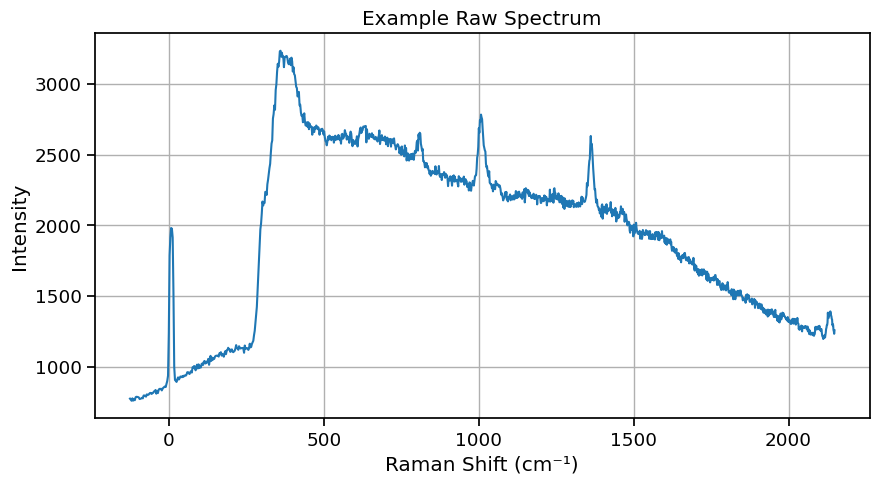

In [2]:
def wavelength_to_raman_shift(wavelength: np.ndarray, laser_wavelength: float = 785.0) -> np.ndarray:
    """
    Convert wavelength to Raman shift in cm^-1.
    
    Args:
        wavelength: Array of wavelengths in nm
        laser_wavelength: Excitation wavelength in nm
        
    Returns:
        Array of Raman shifts in cm^-1
    """
    return (1/laser_wavelength - 1/wavelength) * 1e7

def get_concentration(filename: str) -> float:
    """
    Extract concentration from filename.
    Returns 0.0 for PBS samples, otherwise extracts the concentration value.
    """
    if 'PBS' in filename:
        return 0.0
    else:
        # Find the part that contains the concentration
        parts = filename.split('_')
        for part in parts:
            if 'uM' in part:
                return float(part.replace('uM', ''))
    return 0.0  # Default to 0 if not found

def load_and_parse_data(data_dir: str = "data_raw") -> tuple[np.ndarray, np.ndarray, np.ndarray, list]:
    """
    Load and parse all Raman spectra from the data directory.
    
    Args:
        data_dir: Directory containing the .npz files
        
    Returns:
        spectra: Array of shape (n_samples, n_wavelengths)
        raman_shifts: Array of Raman shift values in cm^-1
        concentrations: Array of concentrations
        metadata: List of dictionaries containing file metadata
    """
    # Get all .npz files
    npz_files = glob(os.path.join(data_dir, "*.npz"))
    
    # Initialize lists
    spectra = []
    wavelengths = None
    concentrations = []
    metadata = []
    
    for npz_file in npz_files:
        # Load spectrum data
        data = np.load(npz_file)
        
        # Store wavelength data from first file
        if wavelengths is None:
            wavelengths = data['wavelength']
            
        # Get intensities - this is a 2D array with multiple measurements
        intensities = data['intensities']  # Shape: (n_measurements, n_wavelengths)
        
        # Parse filename for metadata
        fname = os.path.basename(npz_file)
        parts = fname.split('_')
        
        # Get concentration (0 for PBS, actual value for CRN)
        concentration = get_concentration(fname)
        
        # Extract metadata
        meta = {
            'date': parts[2],
            'compound': 'PBS' if 'PBS' in fname else 'CRN',
            'concentration': concentration,
            'laser': 785.0,  # Fixed laser wavelength
            'power': 0.5,    # Fixed power in mW
            'exposure': 10.0  # Fixed exposure time in seconds
        }
        
        # Store each measurement as a separate spectrum
        for intensity in intensities:
            spectra.append(intensity)
            concentrations.append(meta['concentration'])
            metadata.append(meta)
    
    # Convert wavelengths to Raman shift
    raman_shifts = wavelength_to_raman_shift(wavelengths)
    
    # Sort the data by Raman shift (usually displayed from low to high)
    sort_idx = np.argsort(raman_shifts)
    raman_shifts = raman_shifts[sort_idx]
    spectra = np.array(spectra)[:, sort_idx]
    
    return (spectra, 
            raman_shifts,
            np.array(concentrations), 
            metadata)

# Load the data
print("Loading data...")
spectra, raman_shifts, concentrations, metadata = load_and_parse_data()

print(f"Loaded {len(spectra)} spectra")
print(f"Raman shift range: {raman_shifts[0]:.1f} to {raman_shifts[-1]:.1f} cm⁻¹")
print(f"Unique concentrations: {sorted(np.unique(concentrations))} µM")
print(f"Spectrum shape: {spectra[0].shape}")

# Plot an example spectrum with Raman shift
plt.figure(figsize=(10, 5))
plt.plot(raman_shifts, spectra[0])
plt.xlabel('Raman Shift (cm⁻¹)')
plt.ylabel('Intensity')
plt.title('Example Raw Spectrum')
plt.grid(True)
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt, savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from pathlib import Path
from tqdm import tqdm

class RamanSpectrumProcessor:
    def __init__(self, wave_axis=None):
        self.wave_axis = wave_axis
        self.baseline_params = (1e5, 0.01)
        self.smoothing_window = 5
        
    def remove_cosmic_rays(self, spectrum: np.ndarray) -> np.ndarray:
        return medfilt(spectrum, kernel_size=3)
    
    def baseline_correction(self, spectrum: np.ndarray, lam=1e5, p=0.01) -> np.ndarray:
        spectrum = np.asarray(spectrum).ravel()
        L = len(spectrum)
        D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L - 2, L))
        w = np.ones(L)
        for _ in range(10):
            W = sparse.diags(w, 0)
            Z = sparse.linalg.spsolve(W + lam * (D.T @ D), w * spectrum)
            w_new = p * (spectrum > Z) + (1 - p) * (spectrum <= Z)
            if np.allclose(w, w_new):
                break
            w = w_new
        return spectrum - Z
    
    def smooth(self, spectrum: np.ndarray) -> np.ndarray:
        return savgol_filter(spectrum, window_length=7, polyorder=2)
    
    def remove_outliers_pca(self, spectra: np.ndarray, concentration: str, n_components=2, threshold=2.0):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(spectra)
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        mean = np.mean(X_pca, axis=0)
        cov = np.cov(X_pca.T)
        inv_cov = np.linalg.inv(cov)
        diffs = X_pca - mean
        mahal_dist = np.sqrt(np.einsum('ij,jk,ik->i', diffs, inv_cov, diffs))
        mask = mahal_dist < np.mean(mahal_dist) + threshold * np.std(mahal_dist)
        print(f"Removed {(~mask).sum()} outliers from {concentration}")
        return spectra[mask], mask
    
    def normalize_area(self, spectrum: np.ndarray) -> np.ndarray:
        spectrum = np.maximum(spectrum, 0)
        area = np.trapz(spectrum, x=self.wave_axis)
        return spectrum if area == 0 else spectrum / area
    
    def process(self, spectrum: np.ndarray) -> np.ndarray:
        processed = self.baseline_correction(spectrum,
                                             lam=self.baseline_params[0],
                                             p=self.baseline_params[1])
        processed = self.remove_cosmic_rays(processed)
        processed = self.normalize_area(processed)
        processed = self.smooth(processed)
        return processed

# --- INIZIO ELABORAZIONE ---

print("Loading data...")
# Assumiamo che siano già definiti: spectra, raman_shifts, concentrations

processor = RamanSpectrumProcessor(wave_axis=raman_shifts)

print("Processing spectra...")
processed_spectra = []
processed_concentrations = []

# Per salvataggio individuale
output_dir = Path("data_preprocessed")
output_dir.mkdir(parents=True, exist_ok=True)

for concentration in sorted(np.unique(concentrations)):
    mask = concentrations == concentration
    conc_spectra = spectra[mask]

    cleaned_spectra, _ = processor.remove_outliers_pca(
        conc_spectra, concentration=f"{concentration}uM"
    )

    # --- Cartella specifica per questa concentrazione ---
    conc_dir = output_dir / f"{concentration:.1f}uM"
    conc_dir.mkdir(parents=True, exist_ok=True)

    for idx, spectrum in tqdm(enumerate(cleaned_spectra)):
        processed = processor.process(spectrum)
        processed_spectra.append(processed)
        processed_concentrations.append(concentration)

        # --- CROP: 450–2000 cm⁻¹ ---
        crop_min = 450
        crop_max = 2000
        crop_mask = (raman_shifts >= crop_min) & (raman_shifts <= crop_max)
        cropped_spectrum = processed[crop_mask]
        cropped_shift = raman_shifts[crop_mask]

        # --- Salvataggio .npz ---
        np.savez(conc_dir / f"crn_{concentration:.1f}uM_{idx:03d}.npz",
                 raman_shifts=cropped_shift,
                 intensities=cropped_spectrum)

        # --- Salvataggio .png ---
        plt.figure(figsize=(8, 4))
        plt.plot(cropped_shift, cropped_spectrum)
        plt.title(f"{concentration:.1f}µM – Spot {idx}")
        plt.xlabel("Raman Shift (cm⁻¹)")
        plt.ylabel("Intensity (a.u.)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(conc_dir / f"crn_{concentration:.1f}uM_{idx:03d}.png", dpi=300)
        plt.close()


processed_spectra = np.array(processed_spectra)
processed_concentrations = np.array(processed_concentrations)

# --- CROP finale aggregato ---
crop_min = 450
crop_max = 2000
crop_mask = (raman_shifts >= crop_min) & (raman_shifts <= crop_max)
processed_spectra = processed_spectra[:, crop_mask]
raman_shifts = raman_shifts[crop_mask]

# --- STATISTICHE ---
print(f"\n✔ Salvati {len(processed_spectra)} spettri preprocessati in '{output_dir}'")
print(f"Raman shift range: {raman_shifts[0]:.1f} to {raman_shifts[-1]:.1f} cm⁻¹")
print(f"Processed spectrum shape: {processed_spectra.shape[1]} points")
for concentration in sorted(np.unique(processed_concentrations)):
    mask = processed_concentrations == concentration
    print(f"Concentration {concentration}µM: {np.sum(mask)} spectra")



Loading data...
Processing spectra...
Removed 3 outliers from 0.0uM


133it [00:35,  3.78it/s]


Removed 5 outliers from 30.0uM


131it [00:36,  3.59it/s]


Removed 5 outliers from 50.0uM


131it [00:40,  3.27it/s]


Removed 9 outliers from 70.0uM


127it [00:41,  3.04it/s]


Removed 4 outliers from 100.0uM


132it [00:46,  2.85it/s]


Removed 3 outliers from 200.0uM


133it [00:50,  2.65it/s]


Removed 9 outliers from 300.0uM


98it [00:43,  2.25it/s]


✔ Salvati 885 spettri preprocessati in 'data_preprocessed'
Raman shift range: 450.3 to 1999.9 cm⁻¹
Processed spectrum shape: 969 points
Concentration 0.0µM: 133 spectra
Concentration 30.0µM: 131 spectra
Concentration 50.0µM: 131 spectra
Concentration 70.0µM: 127 spectra
Concentration 100.0µM: 132 spectra
Concentration 200.0µM: 133 spectra
Concentration 300.0µM: 98 spectra


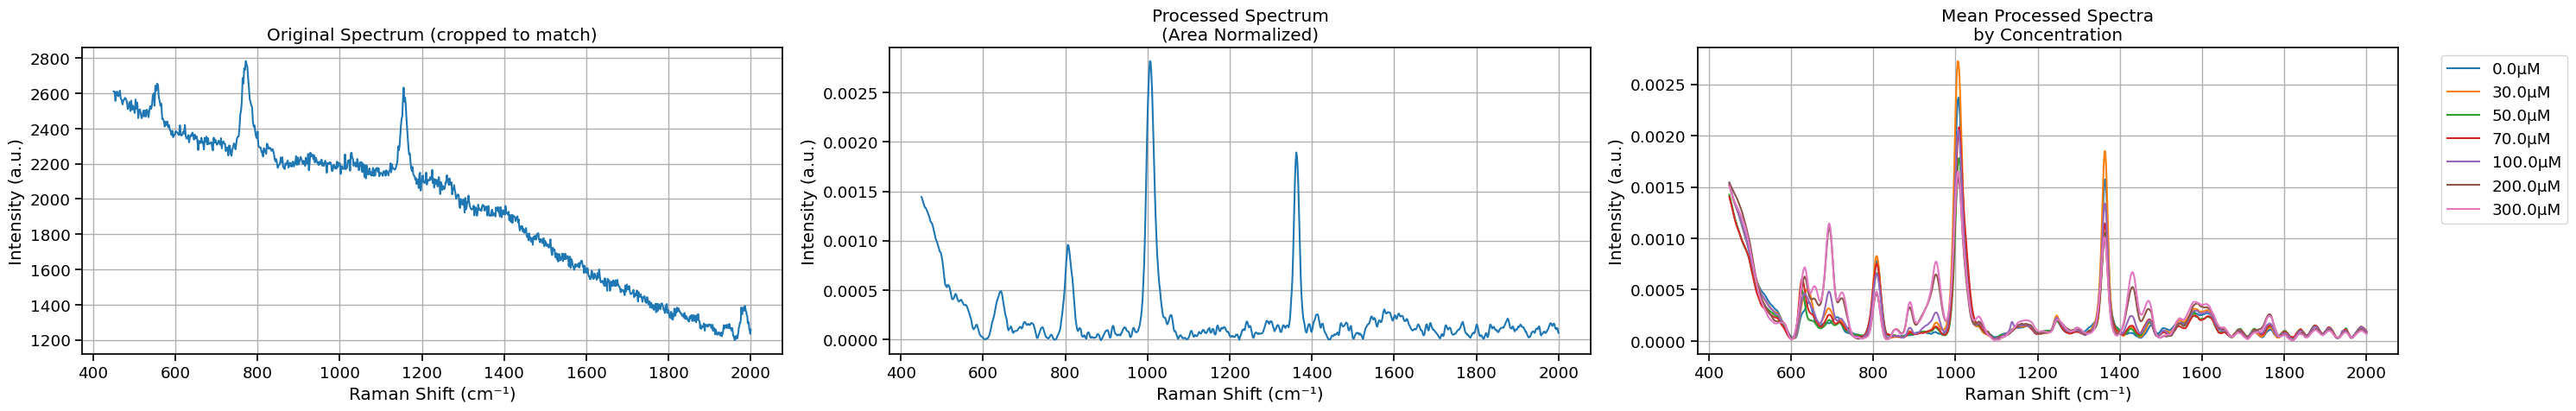

In [7]:
def plot_spectra_comparison(raman_shifts, spectra, processed_spectra, processed_concentrations):
    """
    Plotta:
    - spettro originale (sovrapposto con processed usando lunghezza minima)
    - spettro processato
    - medie per concentrazione
    """

    # Determina quanti punti si possono confrontare direttamente (safe match)
    min_len = min(raman_shifts.shape[0], spectra.shape[1])
    raw_slice = slice(spectra.shape[1] - min_len, spectra.shape[1])
    shift_slice = slice(0, min_len)

    plt.figure(figsize=(30, 5))

    # 1. Originale croppato a match
    plt.subplot(1, 3, 1)
    plt.plot(raman_shifts[shift_slice], spectra[0, raw_slice])
    plt.title('Original Spectrum (cropped to match)')
    plt.xlabel('Raman Shift (cm⁻¹)')
    plt.ylabel('Intensity (a.u.)')
    plt.grid(True)

    # 2. Processato
    plt.subplot(1, 3, 2)
    plt.plot(raman_shifts, processed_spectra[0])
    plt.title('Processed Spectrum\n(Area Normalized)')
    plt.xlabel('Raman Shift (cm⁻¹)')
    plt.ylabel('Intensity (a.u.)')
    plt.grid(True)

    # 3. Medie per concentrazione
    plt.subplot(1, 3, 3)
    for concentration in sorted(np.unique(processed_concentrations)):
        mask = processed_concentrations == concentration
        mean_spectrum = processed_spectra[mask].mean(axis=0)
        plt.plot(raman_shifts, mean_spectrum, label=f'{concentration}µM')
    plt.title('Mean Processed Spectra\nby Concentration')
    plt.xlabel('Raman Shift (cm⁻¹)')
    plt.ylabel('Intensity (a.u.)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()



plot_spectra_comparison(raman_shifts, spectra, processed_spectra, processed_concentrations)

In [10]:
import os
import numpy as np
from glob import glob

# Parametri globali
wv_min = 450.
wv_max = 2000.
required_points = 1024
n_target = 300  # numero di spettri per classe
noise_scale = 0.01  # scala relativa rispetto a std reale

def load_spectra_to_grid_npz(path, wv_min, wv_max, required_points):
    """Carica e interpola tutti gli spettri .npz su una griglia uniforme."""
    wv_grid = np.linspace(wv_min, wv_max, required_points)
    spectra = []
    for file in sorted(glob(os.path.join(path, "*.npz"))):
        data = np.load(file)
        wv = data["raman_shifts"]
        inten = data["intensities"]
        inten_interp = np.interp(wv_grid, wv, inten)
        spectra.append(inten_interp)
    if not spectra:
        raise RuntimeError(f"Nessuno spettro trovato in {path}")
    return wv_grid, np.stack(spectra, axis=0)

def augment_gaussian_noise(spectra: np.ndarray, n_total: int, noise_scale: float = 0.01) -> np.ndarray:
    """
    Genera spettri aggiuntivi con rumore proporzionale alla std dei dati originali.
    
    Args:
        spectra: array [N, L] di spettri reali interpolati
        n_total: numero di spettri da ottenere (inclusi gli originali)
        noise_scale: scala relativa del rumore (es. 0.5 * std punto per punto)

    Returns:
        Array [n_total, L] con spettro reali + augmentati
    """
    n_real, L = spectra.shape
    if n_real >= n_total:
        idx = np.random.choice(n_real, n_total, replace=False)
        return spectra[idx]

    std_pointwise = spectra.std(axis=0)
    needed = n_total - n_real
    augmented = []

    for _ in range(needed):
        base = spectra[np.random.randint(n_real)]
        noise = np.random.normal(0, std_pointwise * noise_scale)
        augmented.append(base + noise)

    return np.vstack([spectra] + augmented)

if __name__ == "__main__":
    root = "data_preprocessed"
    folders = sorted(glob(os.path.join(root, "*uM")))
    print(f"Trovate {len(folders)} cartelle.")

    for folder in folders:
        print(f"→ Processing: {folder}")
        try:
            wv_grid, spectra_interp = load_spectra_to_grid_npz(folder, wv_min, wv_max, required_points)
            augmented = augment_gaussian_noise(spectra_interp, n_target, noise_scale=noise_scale)
            np.save(os.path.join(folder, f"augmented_{n_target}.npy"), augmented)
            print(f"  ✔ Salvato augmented_{n_target}.npy con shape {augmented.shape}")
        except Exception as e:
            print(f"  ❌ Errore in {folder}: {e}")


Trovate 7 cartelle.
→ Processing: data_preprocessed\0.0uM
  ✔ Salvato augmented_300.npy con shape (300, 1024)
→ Processing: data_preprocessed\100.0uM
  ✔ Salvato augmented_300.npy con shape (300, 1024)
→ Processing: data_preprocessed\200.0uM
  ✔ Salvato augmented_300.npy con shape (300, 1024)
→ Processing: data_preprocessed\30.0uM
  ✔ Salvato augmented_300.npy con shape (300, 1024)
→ Processing: data_preprocessed\300.0uM
  ✔ Salvato augmented_300.npy con shape (300, 1024)
→ Processing: data_preprocessed\50.0uM
  ✔ Salvato augmented_300.npy con shape (300, 1024)
→ Processing: data_preprocessed\70.0uM
  ✔ Salvato augmented_300.npy con shape (300, 1024)
